# Prepare Datasets

In [1]:
!unzip edv.zip -d /content/edv/

Streaming output truncated to the last 5000 lines.
  inflating: /content/edv/edv/0X1225C19111629C6F_f105.jpg  
  inflating: /content/edv/edv/0X1227CDDF6A114129_f66.jpg  
  inflating: /content/edv/edv/0X123F96492CB893D6_f87.jpg  
  inflating: /content/edv/edv/0X1264B4000299A44A_f14.jpg  
  inflating: /content/edv/edv/0X129ED481CEECBD9_f67.jpg  
  inflating: /content/edv/edv/0X12B41FA5409312FE_f179.jpg  
  inflating: /content/edv/edv/0X12B70D2902C13E73_f82.jpg  
  inflating: /content/edv/edv/0X12CF33089E2618A8_f63.jpg  
  inflating: /content/edv/edv/0X12F3CF2F58EC699B_f147.jpg  
  inflating: /content/edv/edv/0X132C1E8DBB715D1D_f55.jpg  
  inflating: /content/edv/edv/0X1351FD090B93589F_f45.jpg  
  inflating: /content/edv/edv/0X13A4AE3152A4D752_f76.jpg  
  inflating: /content/edv/edv/0X13A5F88444B588E0_f49.jpg  
  inflating: /content/edv/edv/0X13CFD73EA4694798_f59.jpg  
  inflating: /content/edv/edv/0X13D9B0A4BC16701D_f84.jpg  
  inflating: /content/edv/edv/0X143B72A804BC7AE7_f57.jpg  
  i

In [2]:

!unzip esv.zip -d /content/esv/

Streaming output truncated to the last 5000 lines.
  inflating: /content/esv/esv/0X1167650B8BEFF863_f111.jpg  
  inflating: /content/esv/esv/0X11751D404DAD3313_f96.jpg  
  inflating: /content/esv/esv/0X1185DA5AB0D9BE6A_f54.jpg  
  inflating: /content/esv/esv/0X11F7628563B5B391_f114.jpg  
  inflating: /content/esv/esv/0X11F798A4F0181ACF_f59.jpg  
  inflating: /content/esv/esv/0X12185F79407DF986_f51.jpg  
  inflating: /content/esv/esv/0X1222EAE9D581E210_f35.jpg  
  inflating: /content/esv/esv/0X1264B4000299A44A_f3.jpg  
  inflating: /content/esv/esv/0X128C3C2C3A7496CB_f62.jpg  
  inflating: /content/esv/esv/0X129682A2ECCD415_f33.jpg  
  inflating: /content/esv/esv/0X12B70D2902C13E73_f55.jpg  
  inflating: /content/esv/esv/0X13031FC2687E954D_f3.jpg  
  inflating: /content/esv/esv/0X1303B567B01D9D71_f107.jpg  
  inflating: /content/esv/esv/0X1364306109381555_f57.jpg  
  inflating: /content/esv/esv/0X13881965FA7312E_f93.jpg  
  inflating: /content/esv/esv/0X139DEEAD6326D6C5_f47.jpg  
  infl

# Model and Dataset Classes

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights



class VolumeRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet_backbone = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC
        self.keypoint_fc = nn.Sequential(
            nn.Linear(80, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )
        self.area_fc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )
        self.combined_fc = nn.Sequential(
            nn.Linear(512 + 128 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, area, keypoints):
        x_img = self.resnet_backbone(image).squeeze()
        x_kp = self.keypoint_fc(keypoints)
        x_area = self.area_fc(area)
        x = torch.cat([x_img, x_kp, x_area], dim=1)
        return self.combined_fc(x).squeeze(1)


In [4]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Dataset
class EFVolumeDataset(Dataset):
    def __init__(self, metadata_path, image_dir):
        with open(metadata_path, 'r') as f:
            self.entries = json.load(f)
        self.image_dir = Path(image_dir)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = self.entries[idx]
        image_filename = f"{item['video_id']}_f{item['frame_num']}.jpg"
        image_path = self.image_dir / image_filename

        image = self.transform(Image.open(image_path).convert("RGB"))
        area = torch.tensor([item["area"]], dtype=torch.float32)
        keypoints = torch.tensor(item["keypoints"], dtype=torch.float32)
        volume = torch.tensor([item["volume"]], dtype=torch.float32)

        return image, area, keypoints, volume

# EDV Regressor Training

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import r2_score

# Paths
metadata_path = "/content/edv/edv/metadata.json"
image_dir = "/content/edv/edv/"

# Dataset
full_dataset = EFVolumeDataset(metadata_path, image_dir)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)
full_dataset = DataLoader(full_dataset, batch_size=16, shuffle=True)

In [ ]:
# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VolumeRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
train_losses = []
val_losses = []
val_r2_scores = []

best_val_loss = float('inf')
patience = 15
patience_counter = 0
best_model_path = "best_model_edv.pt"

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for images, areas, keypoints, volumes in train_loader:
        images, areas, keypoints, volumes = images.to(device), areas.to(device), keypoints.to(device), volumes.to(device)

        preds = model(images, areas, keypoints)
        volumes = volumes.squeeze(1)  # Now volumes is [B] to match preds
        loss = criterion(preds.view(-1), volumes.view(-1))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, areas, keypoints, volumes in val_loader:
            images, areas, keypoints, volumes = images.to(device), areas.to(device), keypoints.to(device), volumes.to(device)
            preds = model(images, areas, keypoints)
            volumes = volumes.squeeze(1)
            loss = criterion(preds.view(-1), volumes.view(-1))
            val_loss += loss.item()

            y_true.extend(volumes.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    r2 = r2_score(y_true, y_pred)
    val_losses.append(val_loss)
    val_r2_scores.append(r2)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val R²: {r2:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)  # save best model
        print("✅ Model improved — saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# Load best model after training
model.load_state_dict(torch.load(best_model_path))


Epoch 1 | Train Loss: 3387.4605 | Val Loss: 698.4106 | Val R²: 0.6377
✅ Model improved — saved.
Epoch 2 | Train Loss: 696.2171 | Val Loss: 654.0315 | Val R²: 0.6613
✅ Model improved — saved.
Epoch 3 | Train Loss: 510.7703 | Val Loss: 813.4750 | Val R²: 0.5814
⚠️ No improvement. Patience: 1/15
Epoch 4 | Train Loss: 400.2299 | Val Loss: 812.2452 | Val R²: 0.5793
⚠️ No improvement. Patience: 2/15
Epoch 5 | Train Loss: 303.5368 | Val Loss: 633.1292 | Val R²: 0.6712
✅ Model improved — saved.
Epoch 6 | Train Loss: 243.3625 | Val Loss: 772.5507 | Val R²: 0.5988
⚠️ No improvement. Patience: 1/15
Epoch 7 | Train Loss: 201.6881 | Val Loss: 639.5721 | Val R²: 0.6670
⚠️ No improvement. Patience: 2/15
Epoch 8 | Train Loss: 177.0076 | Val Loss: 560.9230 | Val R²: 0.7092
✅ Model improved — saved.
Epoch 9 | Train Loss: 163.7402 | Val Loss: 682.7135 | Val R²: 0.6457
⚠️ No improvement. Patience: 1/15
Epoch 10 | Train Loss: 146.9942 | Val Loss: 659.3355 | Val R²: 0.6575
⚠️ No improvement. Patience: 2/15


<All keys matched successfully>

In [ ]:
# Save model
torch.save(model.state_dict(), "edv.pt")

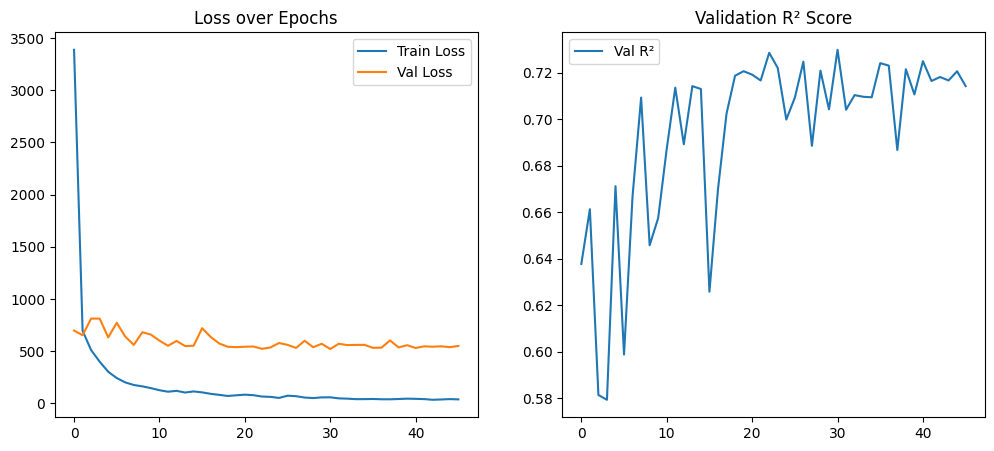

In [ ]:
# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label="Val R²")
plt.title("Validation R² Score")
plt.legend()
plt.show()


In [ ]:
from google.colab import files
files.download('best_model_edv.pt')

In [13]:
import torch
from sklearn.metrics import r2_score

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VolumeRegressor().to(device)
model.load_state_dict(torch.load('best_model_edv.pt', map_location=torch.device('cpu')))

model.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for images, areas, keypoints, volumes in full_dataset:
        images = images.to(device)
        areas = areas.to(device)
        keypoints = keypoints.to(device)
        volumes = volumes.to(device)

        preds = model(images, areas, keypoints)
        test_preds.extend(preds.view(-1).cpu().numpy())
        test_targets.extend(volumes.view(-1).cpu().numpy())

print(f"[DEBUG] Collected {len(test_preds)} predictions and {len(test_targets)} targets")

if len(test_preds) > 0:
    mse = torch.mean((torch.tensor(test_preds) - torch.tensor(test_targets)) ** 2).item()
    r2 = r2_score(test_targets, test_preds)
    print(f"\n📊 Test Loss (MSE): {mse:.4f} | R² Score: {r2:.4f}")
else:
    print("❌ No predictions made — check test_loader or model.")


[DEBUG] Collected 10024 predictions and 10024 targets

📊 Test Loss (MSE): 582.7209 | R² Score: 0.7206


/tmp/ipython-input-4158674025.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


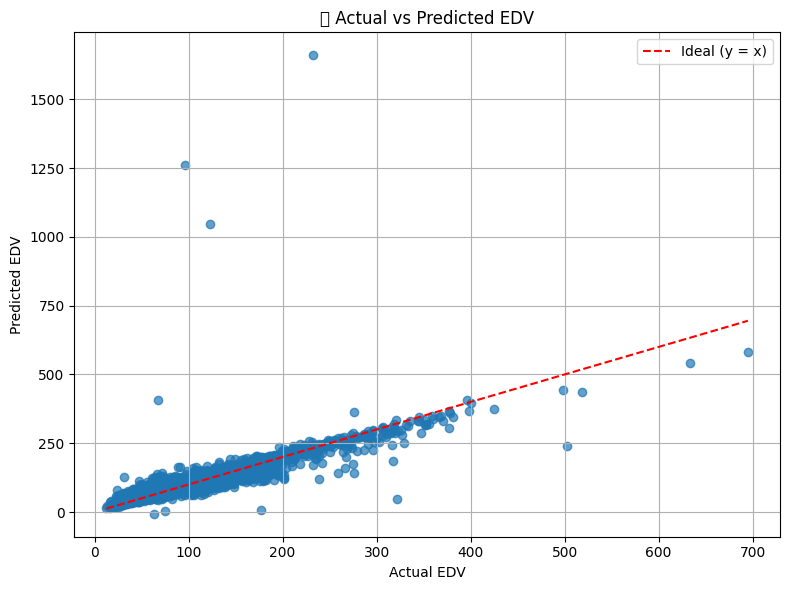

In [14]:
import matplotlib.pyplot as plt

# Convert to numpy arrays (if not already)
import numpy as np
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(test_targets, test_preds, alpha=0.7)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()],
         'r--', label='Ideal (y = x)')
plt.xlabel("Actual EDV")
plt.ylabel("Predicted EDV")
plt.title("📈 Actual vs Predicted EDV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ESV Regressor Training

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import r2_score

# Paths
metadata_path = "/content/esv/esv/metadata.json"
image_dir = "/content/esv/esv/"

# Dataset
full_dataset = EFVolumeDataset(metadata_path, image_dir)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)
full_dataset = DataLoader(full_dataset, batch_size=16, shuffle=True)

In [24]:


# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VolumeRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
train_losses = []
val_losses = []
val_r2_scores = []

best_val_loss = float('inf')
patience = 15
patience_counter = 0
best_model_path = "best_model_esv.pt"

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for images, areas, keypoints, volumes in train_loader:
        images, areas, keypoints, volumes = images.to(device), areas.to(device), keypoints.to(device), volumes.to(device)

        preds = model(images, areas, keypoints)
        volumes = volumes.squeeze(1)  # Now volumes is [B] to match preds
        loss = criterion(preds.view(-1), volumes.view(-1))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, areas, keypoints, volumes in val_loader:
            images, areas, keypoints, volumes = images.to(device), areas.to(device), keypoints.to(device), volumes.to(device)
            preds = model(images, areas, keypoints)
            volumes = volumes.squeeze(1)
            loss = criterion(preds.view(-1), volumes.view(-1))
            val_loss += loss.item()

            y_true.extend(volumes.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    r2 = r2_score(y_true, y_pred)
    val_losses.append(val_loss)
    val_r2_scores.append(r2)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val R²: {r2:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)  # save best model
        print("✅ Model improved — saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# Load best model after training
model.load_state_dict(torch.load(best_model_path))


Epoch 1 | Train Loss: 1075.1120 | Val Loss: 501.7593 | Val R²: 0.5697
✅ Model improved — saved.
Epoch 2 | Train Loss: 438.7433 | Val Loss: 624.0359 | Val R²: 0.4653
⚠️ No improvement. Patience: 1/15
Epoch 3 | Train Loss: 297.9585 | Val Loss: 567.7433 | Val R²: 0.5127
⚠️ No improvement. Patience: 2/15
Epoch 4 | Train Loss: 236.9583 | Val Loss: 375.9125 | Val R²: 0.6775
✅ Model improved — saved.
Epoch 5 | Train Loss: 199.6178 | Val Loss: 363.4295 | Val R²: 0.6886
✅ Model improved — saved.
Epoch 6 | Train Loss: 169.2422 | Val Loss: 340.2305 | Val R²: 0.7087
✅ Model improved — saved.
Epoch 7 | Train Loss: 129.4241 | Val Loss: 328.9133 | Val R²: 0.7177
✅ Model improved — saved.
Epoch 8 | Train Loss: 115.3897 | Val Loss: 417.0330 | Val R²: 0.6419
⚠️ No improvement. Patience: 1/15
Epoch 9 | Train Loss: 112.0005 | Val Loss: 352.5030 | Val R²: 0.6974
⚠️ No improvement. Patience: 2/15
Epoch 10 | Train Loss: 102.0058 | Val Loss: 637.8881 | Val R²: 0.4520
⚠️ No improvement. Patience: 3/15
Epoch 11

<All keys matched successfully>

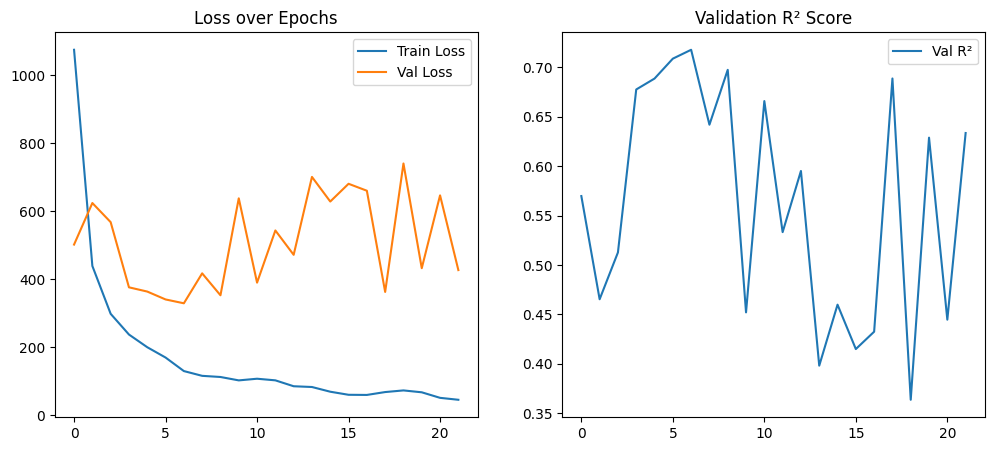

In [25]:
# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label="Val R²")
plt.title("Validation R² Score")
plt.legend()
plt.show()


In [26]:
from google.colab import files
files.download('best_model_esv.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import torch
from sklearn.metrics import r2_score

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VolumeRegressor().to(device)
model.load_state_dict(torch.load('best_model_esv.pt', map_location=torch.device('cpu')))

model.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for images, areas, keypoints, volumes in full_dataset:
        images = images.to(device)
        areas = areas.to(device)
        keypoints = keypoints.to(device)
        volumes = volumes.to(device)

        preds = model(images, areas, keypoints)
        test_preds.extend(preds.view(-1).cpu().numpy())
        test_targets.extend(volumes.view(-1).cpu().numpy())

print(f"[DEBUG] Collected {len(test_preds)} predictions and {len(test_targets)} targets")

if len(test_preds) > 0:
    mse = torch.mean((torch.tensor(test_preds) - torch.tensor(test_targets)) ** 2).item()
    r2 = r2_score(test_targets, test_preds)
    print(f"\n📊 Test Loss (MSE): {mse:.4f} | R² Score: {r2:.4f}")
else:
    print("❌ No predictions made — check test_loader or model.")


[DEBUG] Collected 10024 predictions and 10024 targets

📊 Test Loss (MSE): 142.6793 | R² Score: 0.8889


/tmp/ipython-input-2565453926.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


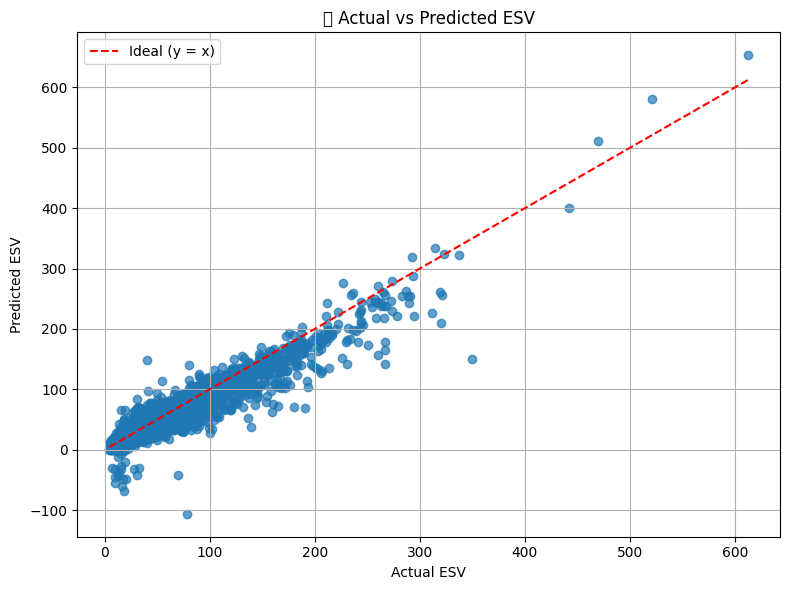

In [17]:
import matplotlib.pyplot as plt

# Convert to numpy arrays (if not already)
import numpy as np
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(test_targets, test_preds, alpha=0.7)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()],
         'r--', label='Ideal (y = x)')
plt.xlabel("Actual ESV")
plt.ylabel("Predicted ESV")
plt.title("📈 Actual vs Predicted ESV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
